# Import packages & Setting up tensorboard

In [20]:
import matplotlib.pyplot as plt
import random
from keras.datasets import cifar10  #Dataset
import tensorflow as tf
from tensorflow.keras.utils import to_categorical #One hot encoding

from sklearn.model_selection import KFold #Cross validation
import numpy as np
import math

import datetime
import os

In [2]:
#To visualise tensorboard, please type in    " tensorboard --logdir=logs/fit --host localhost --port 8088 "   into the command line, and then visit localhost:8088 on your web browser

os.environ['TENSORBOARD_BINARY'] = 'C:/Users/benat/anaconda3/Lib/site-packages/tensorboard' #Change path accordingly
%load_ext tensorboard

# Load & Visualise data

In [3]:
# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


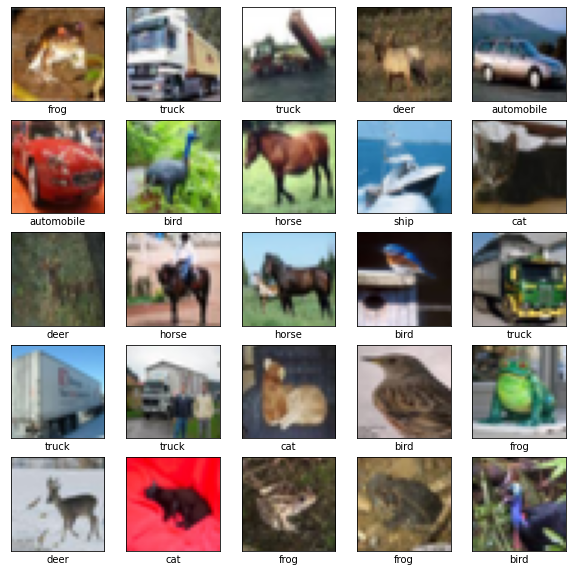

In [4]:
#Label images with appropaite classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i])
    plt.xlabel(class_names[trainy[i][0]])
plt.show()

# Pre processing the data

### Normalising pixel values

In [5]:
#Normalise pixel values to have a value between 0-1
trainX, testX = trainX.astype('float32'), testX.astype('float32')
trainX, testX = trainX/255.0, testX/255.0

#One hot encoding for labels
trainy = to_categorical(trainy, num_classes=10)
testy = to_categorical(testy, num_classes=10)

### Creating cutout

In [149]:
#Add a black square of size 12x12 in a random location on the image
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

Original images:


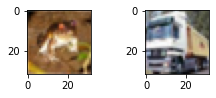

Images with cutout:


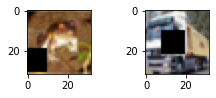

In [150]:
#Visualise the image with cutout
print("Original images:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow(trainX[i])
plt.show()
print("Images with cutout:")
for i in range(2):
    plt.subplot(330 + 1 + i)
    img = np.copy(trainX[i])
    plt.imshow(apply_mask(img))
plt.show()

In [151]:
#Batch generator for images with cutout
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size

### CutMix

In [6]:
#For some reason, we cannot visualise the reconstructed image with CutMix, if we perform normalisation
np.random.seed(42)
tf.random.set_seed(42)

# load dataset
(trainX, trainy), (testX, testy) = cifar10.load_data()
# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

#One hot encoding for labels
trainy = to_categorical(trainy, num_classes=10)
testy = to_categorical(testy, num_classes=10)

AUTO = tf.data.AUTOTUNE
BATCH_SIZE = 32
IMG_SIZE = 32

def preprocess_image(image, label): #Convert image to tensorflow object
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.image.convert_image_dtype(image, tf.float32) / 255.0
    return image, label

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


In [7]:
#We get an error if we run this on GPU
with tf.device('/device:CPU:0'):
  train_ds_one = (
    tf.data.Dataset.from_tensor_slices((trainX, trainy))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
  )
  train_ds_two = (
    tf.data.Dataset.from_tensor_slices((trainX, trainy))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
  )


  test_ds = tf.data.Dataset.from_tensor_slices((testX, testy))


# Combine two shuffled datasets from the same training data.
  train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

  test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
  )

In [8]:
#Get a particular size of the cutout image to apply to the original image
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

#Cut a fragment of the image to apply to the orignal image
@tf.function
def get_box(lambda_value):
    cut_rat = tf.math.sqrt(1.0 - lambda_value)

    cut_w = IMG_SIZE * cut_rat  
    cut_w = tf.cast(cut_w, tf.int32)

    cut_h = IMG_SIZE * cut_rat  
    cut_h = tf.cast(cut_h, tf.int32)

    cut_x = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  
    cut_y = tf.random.uniform((1,), minval=0, maxval=IMG_SIZE, dtype=tf.int32)  

    boundaryx1 = tf.clip_by_value(cut_x[0] - cut_w // 2, 0, IMG_SIZE)
    boundaryy1 = tf.clip_by_value(cut_y[0] - cut_h // 2, 0, IMG_SIZE)
    bbx2 = tf.clip_by_value(cut_x[0] + cut_w // 2, 0, IMG_SIZE)
    bby2 = tf.clip_by_value(cut_y[0] + cut_h // 2, 0, IMG_SIZE)

    target_h = bby2 - boundaryy1
    if target_h == 0:
        target_h += 1

    target_w = bbx2 - boundaryx1
    if target_w == 0:
        target_w += 1

    return boundaryx1, boundaryy1, target_h, target_w


@tf.function
def cutmix(train_ds_one, train_ds_two):
    (image1, label1), (image2, label2) = train_ds_one, train_ds_two

    alpha = [0.25]
    beta = [0.25]

    # Get a sample from the Beta distribution
    lambda_value = sample_beta_distribution(1, alpha, beta)

    # Define Lambda
    lambda_value = lambda_value[0][0]

    # Get the bounding box offsets, heights and widths
    boundaryx1, boundaryy1, target_h, target_w = get_box(lambda_value)

    # Get a patch from the second image (`image2`)
    crop2 = tf.image.crop_to_bounding_box(
        image2, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image2` patch (`crop2`) with the same offset
    image2 = tf.image.pad_to_bounding_box(
        crop2, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )
    # Get a patch from the first image (`image1`)
    crop1 = tf.image.crop_to_bounding_box(
        image1, boundaryy1, boundaryx1, target_h, target_w
    )
    # Pad the `image1` patch (`crop1`) with the same offset
    img1 = tf.image.pad_to_bounding_box(
        crop1, boundaryy1, boundaryx1, IMG_SIZE, IMG_SIZE
    )

    # Modify the first image by subtracting the patch from `image1`
    # (before applying the `image2` patch)
    image1 = image1 - img1
    # Add the modified `image1` and `image2`  together to get the CutMix image
    image = image1 + image2

    # Adjust Lambda in accordance to the pixel ration
    lambda_value = 1 - (target_w * target_h) / (IMG_SIZE * IMG_SIZE)
    lambda_value = tf.cast(lambda_value, tf.float32)

    # Combine the labels of both images
    label = lambda_value * label1 + (1 - lambda_value) * label2
    return image, label


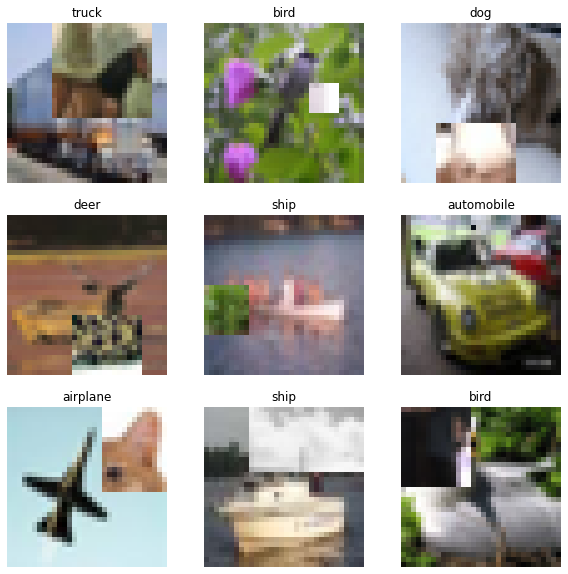

In [9]:
# Create the new dataset using our `cutmix` utility
train_ds_cmu = (
    train_ds.shuffle(1024)
    .map(cutmix, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

# Let's preview 9 samples from the dataset
image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.imshow(image_batch[i])
    plt.axis("off")

### K-fold

In [10]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []


# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# Defining the model

In [11]:
class CNN_Model(tf.keras.Model):
  def __init__(self, batch_size, depth, hidden_neurons_1, hidden_neurons_2, hidden_neurons_3, kernel_size_1, kernel_size_2, kernel_size_3,
               dropout_rate, batch_norm, pooling, layer_activation_1, layer_activation_2, layer_activation_3,
               kernel_initialiser, bias_initialiser, optimiser, weight_decay, learning_rate, output_activation, SGD_momentum, use_cutout=False):
    super(CNN_Model,self).__init__()
    
    ############ Batch Size ###############
    self.batch_size = batch_size        
    #######################################


    ############ Conv2D hyperparameters ###############
    self.hidden_neurons_1=hidden_neurons_1
    self.kernel_size_1=kernel_size_1

    self.hidden_neurons_2=hidden_neurons_2
    self.kernel_size_2=kernel_size_2

    self.hidden_neurons_3=hidden_neurons_3
    self.kernel_size_3=kernel_size_3
    ####################################################


    ############ Other layers in the model #####################
    if pooling=='max':
      self.pooling = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')
    elif pooling=='average':
      self.pooling = tf.keras.layers.AveragePooling2D(pool_size=(2,2), padding='same')
    ############################################################
    self.batch_norm=batch_norm
    ############################################################
    self.dropout_rate=dropout_rate
    ############################################################


    ############ Activation functions #########################
    self.layer_activation_1 = layer_activation_1
    self.layer_activation_2 = layer_activation_2
    self.layer_activation_3 = layer_activation_3

    self.output_activation = output_activation
    ############################################################


    ####################### Learning rate #################################
    self.learning_rate = learning_rate
    ###############################################################################
    

    ################################### Optimiser #################################
    self.momentum = SGD_momentum
    if optimiser=='Adam':
      self.optimizer=tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
    elif optimiser=='SGD':
      self.optimizer=tf.keras.optimizers.SGD(learning_rate=self.learning_rate, momentum=self.momentum)
    elif optimiser=='RMSprop':
      self.optimizer=tf.keras.optimizers.RMSprop(learning_rate=self.learning_rate)
    ###############################################################################


    ####################### Weight initialisation #################################
    self.kernel_initialiser=kernel_initialiser
    self.bias_initialiser=bias_initialiser
    ###############################################################################


    ####################### Weight decay #################################
    self.weight_decay = weight_decay
    ###############################################################################

    ####################### Cutout #################################
    self.cutout = use_cutout
    ###############################################################################


################################################################################################# The Model ####################################################################################################################
#################################################################################################################################################################################################################################



    self.model = tf.keras.Sequential()

    #Input layer
    self.model.add(tf.keras.layers.InputLayer(input_shape=(32, 32, 3)))

    #1st hidden layer
    self.model.add(tf.keras.layers.Conv2D(filters=self.hidden_neurons_1, kernel_size=self.kernel_size_1, activation=self.layer_activation_1,
                                          kernel_regularizer=self.weight_decay, kernel_initializer=self.kernel_initialiser, bias_initializer=self.bias_initialiser, padding='same'))
    if self.batch_norm:
      self.model.add(tf.keras.layers.BatchNormalization())
    if pooling!='None':
      self.model.add(self.pooling)

    #2nd hidden layer
    if depth >=2:
      self.model.add(tf.keras.layers.Conv2D(filters=self.hidden_neurons_2, kernel_size=self.kernel_size_2, activation=self.layer_activation_2,
                                            kernel_regularizer=self.weight_decay, kernel_initializer=self.kernel_initialiser, bias_initializer=self.bias_initialiser, padding='same'))
      if self.batch_norm:
        self.model.add(tf.keras.layers.BatchNormalization())
      if pooling!='None':
        self.model.add(self.pooling)
      self.model.add(tf.keras.layers.Dropout(self.dropout_rate))

    #3rd hidden layer
    if depth>=3:
      self.model.add(tf.keras.layers.Conv2D(filters=self.hidden_neurons_3, kernel_size=self.kernel_size_3, activation=self.layer_activation_3,
                                            kernel_regularizer=self.weight_decay, kernel_initializer=self.kernel_initialiser, bias_initializer=self.bias_initialiser, padding='same'))
      if self.batch_norm:
        self.model.add(tf.keras.layers.BatchNormalization())
      if pooling!='None':
        self.model.add(self.pooling)

    #4th hidden layer (ONLY FOR COMPARISON!)
    if depth>=4:
      self.model.add(tf.keras.layers.Conv2D(filters=256, kernel_size=3, activation='relu',
                                            kernel_regularizer=self.weight_decay, kernel_initializer=self.kernel_initialiser, bias_initializer=self.bias_initialiser))
      if pooling!='None':
        self.model.add(self.pooling)

    #Output layer
    self.model.add(tf.keras.layers.Flatten())
    self.model.add(tf.keras.layers.Dense(units=10, activation=self.output_activation))

    self.model.summary()


################################################################################################# Methods #######################################################################################################################
#################################################################################################################################################################################################################################

  #Exponential learning scheduler
  def lr_schedulerExp(self, epoch, lr):
    if epoch < 15:
      return lr 
    else:
      return lr * tf.math.exp(-0.1)

  #Step learning scheduler
  def lr_schedulerStep(self, epoch, lr):
    drop = 0.5
    epochs_drop = 10.0
    if epoch==10 or epoch==20:
      lr = lr * math.pow(0.5,  
           math.floor((1+epoch)/10.0))
      return lr
    else:
      return lr
    
  #Train on data augmenatation or cutout
  def train(self, train_gen, train_x, train_y, test_x, test_y, lr_rate=True, lr_rate_type='exponential'):
    if lr_rate:
      if lr_rate_type=='exponential':
        callback = tf.keras.callbacks.LearningRateScheduler(self.lr_schedulerExp)
      else:
        callback = tf.keras.callbacks.LearningRateScheduler(self.lr_schedulerStep)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    self.model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    steps = int(train_x.shape[0]/self.batch_size) 
    if lr_rate:
      if self.cutout:
        return self.model.fit(train_gen, epochs=30, validation_data=(test_x, test_y), steps_per_epoch=steps, callbacks=[tensorboard_callback,callback], verbose=1)
      else:
        return self.model.fit(train_gen.flow(train_x, train_y, batch_size=self.batch_size), validation_data=(test_x, test_y) ,steps_per_epoch=steps, epochs=30, callbacks=[tensorboard_callback,callback], verbose=1)  #  self.model.fit(train_x, train_y, validation_data=(test_x, test_y) , epochs=25, verbose=1)
    else:
      return self.model.fit(train_gen.flow(train_x, train_y, batch_size=self.batch_size), validation_data=(test_x, test_y) ,steps_per_epoch=steps, epochs=30, callbacks=[tensorboard_callback], verbose=1)
    
  #Train on CutMix
  def train_mix(self,train_ds, val_ds, lr_rate=True, lr_rate_type='exponential'):
    if lr_rate:
      if lr_rate_type=='exponential':
        callback = tf.keras.callbacks.LearningRateScheduler(self.lr_schedulerExp)
      else:
        callback = tf.keras.callbacks.LearningRateScheduler(self.lr_schedulerStep)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    self.model.compile(optimizer=self.optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    if lr_rate:
      return self.model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[tensorboard_callback, callback], verbose=1)
    else:
      return self.model.fit(train_ds, validation_data=val_ds, epochs=30, callbacks=[tensorboard_callback], verbose=1)
     
  def evaluate(self, test_x, test_y):
    return self.model.evaluate(test_x, test_y, verbose=0)

  def evaluate_mix(self, test_ds):
    return self.model.evaluate(test_ds)

# Training the model

## Setting GPU

In [12]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### CNN model

## Learning rate

##### Learning_rate=0.1 & Exponential decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []
with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
              dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=0.1, output_activation='softmax', SGD_momentum=0)
  
    #Data augmentation
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid])

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 8, 8, 64)          0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                        

##### Learning_rate=0.1 & No decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=0.1, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])  #Data Augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate=False)  #Don't use learning scheduler

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_43 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_14 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_44 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_14 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=0.1 & Step decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=0.1, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data Augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step') #Step learning scheduler

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                      

##### Learning_rate=1e-3 & Exponential decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])  #Data Augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid])

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=1e-3 & No decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])  #Data Augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate=False)  

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_45 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_15 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_46 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_15 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_47 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_15 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=1e-3 & Step decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_62 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_20 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=1e-5 & Exponential decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-5, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid])

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_25 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_25 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_77 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_25 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=1e-5 & No decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-5, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate=False)

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_30 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_30 (Flatten)        (None, 2048)              0         
                                                     

##### Learning_rate=1e-5 & Step decay

In [ ]:
# K-fold Cross Validation model evaluation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-5, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_35 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 dropout_35 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_107 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 flatten_35 (Flatten)        (None, 2048)              0         
                                                     

## Network depth, width and maxpool

##### 2 hidden layers and Wide Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=2, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])      #Data Augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step') #Step decay

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_120 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_40 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_40 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 flatten_40 (Flatten)        (None, 8192)              0         
                                                                 
 dense_40 (Dense)            (None, 10)                81930     
                                                     

##### 2 hidden layers and Middle Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=2, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_45 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_131 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 dropout_45 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 flatten_45 (Flatten)        (None, 4096)              0         
                                                                 
 dense_45 (Dense)            (None, 10)                40970     
                                                     

##### 2 hidden layers and Narrow Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=2, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_140 (Conv2D)         (None, 32, 32, 4)         112       
                                                                 
 max_pooling2d_50 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_141 (Conv2D)         (None, 16, 16, 32)        1184      
                                                                 
 dropout_50 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 flatten_50 (Flatten)        (None, 2048)              0         
                                                                 
 dense_50 (Dense)            (None, 10)                20490     
                                                     

##### 3 hidden layers and Wide Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_151 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_55 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_152 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_55 (Flatten)        (None, 4096)              0         
                                                     

##### 3 hidden layers and Middle Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_60 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_166 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 dropout_60 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_167 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 flatten_60 (Flatten)        (None, 2048)              0         
                                                     

##### 3 hidden layers and Narrow Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_180 (Conv2D)         (None, 32, 32, 4)         112       
                                                                 
 max_pooling2d_65 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_181 (Conv2D)         (None, 16, 16, 32)        1184      
                                                                 
 dropout_65 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 conv2d_182 (Conv2D)         (None, 8, 8, 64)          18496     
                                                                 
 flatten_65 (Flatten)        (None, 1024)              0         
                                                     

##### 4 hidden layers and Wide Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=4, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         590080    
                                                        

##### 4 hidden layers and Middle Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=4, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_5 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_22 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 conv2d_23 (Conv2D)          (None, 2, 2, 256)         295168    
                                                      

##### 4 hidden layers and Narrow Structure

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=4, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 32, 32, 4)         112       
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 16, 16, 32)        1184      
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 conv2d_42 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 conv2d_43 (Conv2D)          (None, 2, 2, 256)         147712    
                                                     

##### 3 hidden layers, Wide and Kernel size 3x3

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_15 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_61 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_15 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_62 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_15 (Flatten)        (None, 4096)              0         
                                                     

##### 3 hidden layers, Middle and Kernel size 3x3

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_20 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_20 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_77 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_20 (Flatten)        (None, 2048)              0         
                                                     

##### 3 hidden layers, Narrow and Kernel size 3x3

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_90 (Conv2D)          (None, 32, 32, 4)         112       
                                                                 
 max_pooling2d_25 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 16, 16, 32)        1184      
                                                                 
 dropout_25 (Dropout)        (None, 8, 8, 32)          0         
                                                                 
 conv2d_92 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 flatten_25 (Flatten)        (None, 1024)              0         
                                                     

##### 3 hidden layers, Wide and Kernel size 5x5

In [11]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=5, kernel_size_2=5, kernel_size_3=5, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204928    
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         819456    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                        

KeyboardInterrupt: ignored

##### 3 hidden layers, Middle and Kernel size 5x5

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=5, kernel_size_2=5, kernel_size_3=5, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### 3 hidden layers, Narrow and Kernel size 5x5

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=5, kernel_size_2=5, kernel_size_3=5, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### 3 hidden layers, Wide and Kernel size 7x7

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=7, kernel_size_2=7, kernel_size_3=7, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### 3 hidden layers, Middle and Kernel size 7x7

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=7, kernel_size_2=7, kernel_size_3=7, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0, SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### 3 hidden layers, Narrow and Kernel size 7x7

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=4, hidden_neurons_2=32, hidden_neurons_3=64, kernel_size_1=7, kernel_size_2=7, kernel_size_3=7, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### Max pooling

In [12]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_3 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_3 (Flatten)         (None, 4096)              0         
                                                      

##### Average pooling

In [13]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='average', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 average_pooling2d (AverageP  multiple                 0         
 ooling2D)                                                       
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_8 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_26 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_8 (Flatten)         (None, 4096)              0         
                                                      

KeyboardInterrupt: ignored

##### No pooling

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='None', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

## Batch normalisation, batch sizes and dropout rate

##### Drop out rate 0

In [14]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_9 (Dropout)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_29 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_9 (Flatten)         (None, 4096)              0         
                                                      

KeyboardInterrupt: ignored

##### Drop out rate 0.4

In [15]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_11 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_11 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Drop out rate 0.8

In [16]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.8, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_13 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_41 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_13 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Batch norm with batch size 32

In [16]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=True, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d_7 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

KeyboardInterrupt: ignored

##### Batch size 32

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### Batch norm with batch size 64

In [17]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=64, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=True, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_3 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_25 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_4 (Batc  (None, 16, 16, 64)       256       
 hNormalization)                                                 
                                                      

KeyboardInterrupt: ignored

##### Batch size 64

In [18]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=64, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_10 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_32 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_10 (Flatten)        (None, 2048)              0         
                                                     

KeyboardInterrupt: ignored

##### Batch norm with batch size 256

In [19]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=256, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=True, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_9 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_12 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                     

KeyboardInterrupt: ignored

##### Batch size 256

In [15]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=256, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_2 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                      

## Weight initialisation, decay and activation functions

###### Relu activation

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

###### Tanh activation

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='tanh', layer_activation_2='tanh', layer_activation_3='tanh',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_105 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_35 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_106 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_35 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_107 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_35 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### No layer activation

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1=None, layer_activation_2=None, layer_activation_3=None,
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_111 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_37 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_112 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_37 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_113 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_37 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

###### Xavier initialiser and no weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax') #tf.keras.regularizers.l2(0.001)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid])

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### Xavier initialiser and no decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### Xavier initialiser and 1e-3 decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-3), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_117 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_39 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_118 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_39 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_119 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_39 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Xavier initialiser and 1e-5 decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-5), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_41 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_124 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_41 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_125 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_41 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### He initaliser No weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_43"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_129 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_43 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_130 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_43 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_131 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_43 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### He initialiser and 1e-3 weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-3), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_135 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_45 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_136 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_45 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_137 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_45 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### He initialiser and 1e-5 weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-5), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

##### Random initialiser and no decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.RandomUniform(), bias_initialiser='zeros', optimiser='Adam', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_46"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_138 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_46 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_139 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_46 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_140 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_46 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Random initialiser and 1e-3 weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.RandomUniform(), bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-3), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_150 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_50 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_151 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_50 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_152 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_50 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Random initialiser and 1e-5 weight decay

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.RandomUniform(), bias_initialiser='zeros', optimiser='Adam', weight_decay=tf.keras.regularizers.l2(1e-5), learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_159 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_53 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_160 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_53 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_161 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_53 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

## Optimisers

##### SGD: Learning rate 1e-2 Momentum 0.3

In [137]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.3) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_23 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_73 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_24 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_74 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_24 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-2 Momentum 0.6

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.6) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_174 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_58 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_175 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_58 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_176 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_58 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-2 Momentum 0.9

In [138]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.9)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_75 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_76 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_25 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_77 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_25 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-3 Momentum 0.3

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0.3)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_63"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_189 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_63 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_190 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_63 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_191 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_63 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-3 Momentum 0.6

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0.6) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_195 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_65 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_196 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_65 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_197 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_65 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-3 Momentum 0.9

In [139]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0.9) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_78 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_25 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_79 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_26 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_80 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_26 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-4 Momentum 0.3

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-4, output_activation='softmax', SGD_momentum=0.3) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_67"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_201 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_67 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_202 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_67 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_203 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_67 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-4 Momentum 0.6

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-4, output_activation='softmax', SGD_momentum=0.6) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_68"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_204 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_68 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_205 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_68 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_206 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_68 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD: Learning rate 1e-4 Momentum 0.9

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser=tf.keras.initializers.HeNormal(), bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-4, output_activation='softmax', SGD_momentum=0.9) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step') 

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_207 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_69 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_208 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_69 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_209 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_69 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### SGD no momentum

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train]) #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_165 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_166 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_55 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_167 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_55 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### RMSProp

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='glorot_uniform', bias_initialiser='zeros', optimiser='RMSprop', weight_decay=None, learning_rate=1e-3, output_activation='softmax', SGD_momentum=0)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])  #Data augmentation
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_122 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_34 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_123 (Conv2D)         (None, 16, 16, 64)        18496     
                                                                 
 dropout_39 (Dropout)        (None, 8, 8, 64)          0         
                                                                 
 conv2d_124 (Conv2D)         (None, 8, 8, 128)         73856     
                                                                 
 flatten_39 (Flatten)        (None, 2048)              0         
                                                     

KeyboardInterrupt: ignored

## Comparing data augmentaion, cutout, mixup and cutmix

##### Data augmentation

In [ ]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='he_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=0.01, output_activation='softmax', SGD_momentum=0.9) 
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True)
    train_gen.fit(trainX[train])
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              train_gen,
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_71"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_213 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_71 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_214 (Conv2D)         (None, 16, 16, 128)       73856     
                                                                 
 dropout_71 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_215 (Conv2D)         (None, 8, 8, 256)         295168    
                                                                 
 flatten_71 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### Cutout

In [152]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='he_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax',use_cutout=True, SGD_momentum=0.9) 

  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    history = model.train(
              batch_generator(
                trainX[train],
                trainy[train],
                m=8,
                batch_size=32,
                epochs=30, 
                augment=apply_mask
              ),
                trainX[train],
                  trainy[train],
                trainX[valid],
                  trainy[valid],
                  lr_rate_type='step')

    scores = model.evaluate(trainX[valid], trainy[valid])

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_84 (Conv2D)          (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_27 (MaxPoolin  multiple                 0         
 g2D)                                                            
                                                                 
 conv2d_85 (Conv2D)          (None, 16, 16, 128)       73856     
                                                                 
 dropout_28 (Dropout)        (None, 8, 8, 128)         0         
                                                                 
 conv2d_86 (Conv2D)          (None, 8, 8, 256)         295168    
                                                                 
 flatten_28 (Flatten)        (None, 4096)              0         
                                                     

KeyboardInterrupt: ignored

##### CutMix

In [21]:
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):
  fold_no = 1
  for train, valid in kfold.split(trainX, trainy):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=64, hidden_neurons_2=128, hidden_neurons_3=256, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.2, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='he_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.9) 
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    train_ds_one = (
    tf.data.Dataset.from_tensor_slices((trainX[train], trainy[train]))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    )
    train_ds_two = (
      tf.data.Dataset.from_tensor_slices((trainX[train], trainy[train]))
      .shuffle(1024)
      .map(preprocess_image, num_parallel_calls=AUTO)
    )

    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    train_ds_cmu = (
      train_ds.shuffle(1024)
      .map(cutmix, num_parallel_calls=AUTO)
      .batch(BATCH_SIZE)
      .prefetch(AUTO)
      )
    
    val_ds = tf.data.Dataset.from_tensor_slices((trainX[valid], trainy[valid]))

    val_ds = (
    val_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
    )

    history = model.train_mix(
              train_ds_cmu,
                val_ds,
                lr_rate_type='step')

    scores = model.evaluate_mix(val_ds)

    print(f'Score for fold {fold_no}: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no+=1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 dropout (Dropout)           (None, 8, 8, 128)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 256)         295168    
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                        

KeyboardInterrupt: ignored

# Training model on full dataset and testing

In [32]:
#Best achieving model 77.3% accuracy for 3 hidden layers without batch normalisation and using data augmentation
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='he_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.9)
  
    train_gen = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True) #Data Augmentation
    train_gen.fit(trainX)
  
    print('------------------------------------------------------------------------')
    print('Training with full data')

    history = model.train(
              train_gen,
                trainX,
                  trainy,
                testX,
                  testy,
                  lr_rate_type='step')

    scores = model.evaluate(testX, testy)
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (None, 16, 16, 64)        18496     
                                                                 
 dropout_4 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_14 (Conv2D)          (None, 8, 8, 128)         73856     
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                      

In [14]:
#Model achieved 76.2% accuracy for 3 hidden layers without batch normalisation and using cut mix
acc_per_fold = []
loss_per_fold = []

with tf.device('/device:GPU:0'):

    model = CNN_Model(batch_size=32, depth=3, hidden_neurons_1=32, hidden_neurons_2=64, hidden_neurons_3=128, kernel_size_1=3, kernel_size_2=3, kernel_size_3=3, 
               dropout_rate=0.4, batch_norm=False, pooling='max', layer_activation_1='relu', layer_activation_2='relu', layer_activation_3='relu',
               kernel_initialiser='he_uniform', bias_initialiser='zeros', optimiser='SGD', weight_decay=None, learning_rate=1e-2, output_activation='softmax', SGD_momentum=0.9) 
  
    print('------------------------------------------------------------------------')
    print(f'Training for fold full training data ...')

    train_ds_one = (
    tf.data.Dataset.from_tensor_slices((trainX, trainy))
    .shuffle(1024)
    .map(preprocess_image, num_parallel_calls=AUTO)
    )
    train_ds_two = (
      tf.data.Dataset.from_tensor_slices((trainX, trainy))
      .shuffle(1024)
      .map(preprocess_image, num_parallel_calls=AUTO)
    )

    train_ds = tf.data.Dataset.zip((train_ds_one, train_ds_two))

    train_ds_cmu = (
      train_ds.shuffle(1024)
      .map(cutmix, num_parallel_calls=AUTO)
      .batch(64)
      .prefetch(AUTO)
      )   #Modifying training data for CutMix
    
    test_ds = tf.data.Dataset.from_tensor_slices((testX, testy))

    test_ds = (
    test_ds.map(preprocess_image, num_parallel_calls=AUTO)
    .batch(64)
    .prefetch(AUTO)
    )  #Modifying testing data for CutMix

    history = model.train_mix(
              train_ds_cmu,
                test_ds,
                lr_rate_type='step')  #CutMix data augmentation

    scores = model.evaluate_mix(test_ds)

    print(f'Model score: loss of {scores[0]}; accuracy of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 64)          0         
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 128)         73856     
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                      